In [1]:
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from common.util import tokenize_texts

In [2]:
columns = ['target', 'id', 'date', 'query', 'user', 'text']
tweets = pd.read_csv('../../data/tweets/Data_tweets.csv', header=None, names=columns)

In [3]:
# Check unique query values
set(tweets['query'])

{'NO_QUERY'}

The query field has only one value, so it does not distinguish tweets at all.
This field is completely useless for classification and should be removed.

In [4]:
tweets = tweets.drop('query', axis=1)

In [5]:
# Check whether duplicates exist
duplicates = tweets[tweets.duplicated('text')]

print(f'{len(duplicates)} duplicate tweet texts detected')

49 duplicate tweet texts detected


In [6]:
# Check for duplicates with conflicting labels
conflicts = duplicates[['target', 'text']].groupby('text').agg(['unique', 'nunique'])
conflicts = conflicts[conflicts['target']['nunique'] > 1]

print(f'Number of tweets with same text but different polarity: {sum(conflicts["target"]["nunique"])}')

Number of tweets with same text but different polarity: 2


In [7]:
# Display the conflicting tweets
conflicts

target        
          unique nunique
text                    
At work   [4, 0]       2

In [8]:
tweets[tweets['text'] == 'At work ']

,target,id,date,user,text
11765,0,2227044159,Thu Jun 18 12:42:24 PDT 2009,myoung1008,At work
13148,4,2190271424,Tue Jun 16 02:15:09 PDT 2009,pretty_sara,At work
24407,0,2208369667,Wed Jun 17 09:06:49 PDT 2009,webbywebster,At work


The two *"At work"* tweets, have positive and negative polarity.
Ironically, the tweets with negative polarity are written during working hours, but the positive one was written when someone was working at 2 am.
These examples are good for learning the mapping between time of the day and the polarity, so they should be kept.
Generally, duplicates have different timestamps, so in this dataset keep them.

In [9]:
# Inspect users
print(f'Number of unique users: {len(set(tweets["user"]))}')

Number of unique users: 27770


User ID might be predictive in terms of polarity because users can display proclivity towards "negativity" or "positivity".
Still, in this dataset there are almost as many users as tweets.
Using the user ID here will act as overfitting.
User ID can be good for sentiment analysis when we have a long history of user tweets.
The weight associated with user ID then resembles a prior informing about that user's historical tendency to "negativity" or "positivity", so we can guess the next tweet polarity without seeing it.

In [10]:
# Remove user & tweet IDs
tweets = tweets.drop('user', axis=1)

In [11]:
# Parse the dates
tweets['date'] = pd.to_datetime(tweets['date'], format="%a %b %d %H:%M:%S PDT %Y")

print('The dataset spans the period:')
print(tweets['date'].min())
print(tweets['date'].max())

The dataset spans the period:
2009-04-06 22:21:07
2009-06-25 10:24:32


**Idea**
The time of the day or the week might correlate with polarity.
People might have higher proclivity to send angry tweets at night or be more relaxed during the weekend & send positive tweets then.

Represent time with 4 values:
- cos & sin of timestamp with a period of 24 hours to represent the time of the day
- cos & sin of timestamp with a period of 7 days to represent the day of the week

In this way, the tweets with different dates, but the same day of the week and time of the day share the time representation.

In [12]:
tweets['timestamp'] = tweets.date.values.astype(np.int64) // 10 ** 9

# Period = 2 PI / B
# B = 2 PI / Period
# sin(Bx) / cos(Bx)
week_B = 2 * np.pi / (7 * 24 * 60 * 60)
day_B = 2 * np.pi / (24 * 60 * 60)

tweets['sin day'] = np.sin(tweets['timestamp'] * week_B)
tweets['cos day'] = np.cos(tweets['timestamp'] * week_B)
tweets['sin hour'] = np.sin(tweets['timestamp'] * day_B)
tweets['cos hour'] = np.cos(tweets['timestamp'] * day_B)

# Remove the time representations useless for ML
tweets = tweets.drop(['date', 'timestamp'], axis=1)

negative: 50.2% (15049)
 neutral:  0.0% (    0)
positive: 49.8% (14951)


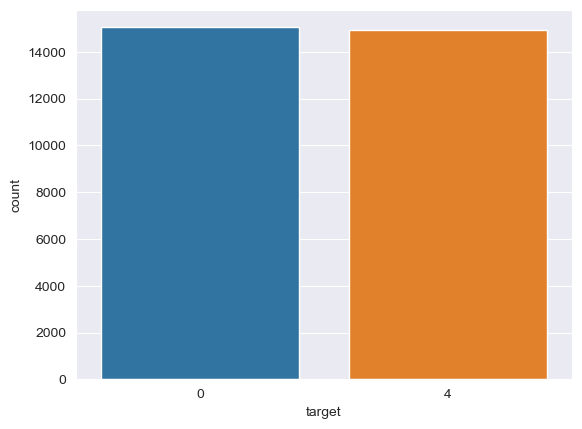

In [13]:
# Check class distributions
sns.countplot(tweets, x='target')
labels = {0: 'negative', 2: 'neutral', 4: 'positive'}

for label_id, label in labels.items():
    class_count = (tweets['target'] == label_id).sum()

    print(f'{label:>8s}: {class_count / len(tweets) * 100:4.1f}% ({class_count:5d})')

There are no neutral tweets, only positive & negative - binary classification.
Classes are balanced, accuracy is a good performance measure.
Baseline - says that every tweet is negative - has 50.2% accuracy.
Split the dataset into train / validation and test sets. (80% / 10% / 10% split)
Preserve class distributions in splits.

In [14]:
# Better labels are 0 & 1 for classifier with sigmoid
tweets['target'] = tweets['target'].apply(lambda target: 1 if target == 4 else 0)

In [15]:
# Use the same format as fake news
text_dict = {'tweets': {row[1]: {'text': row[2], 'input_ids': []} for row in tweets.itertuples(index=False)}}
tweets = tweets.drop('text', axis=1)

In [16]:
# Shuffle the dataset
tweets = tweets.sample(frac=1, random_state=0)

negatives = tweets[tweets['target'] == 0]
positives = tweets[tweets['target'] == 1]

train_negative_idx = int(len(negatives) * 0.8)
train_positive_idx = int(len(positives) * 0.8)
valid_negative_idx = int(len(negatives) * 0.9)
valid_positive_idx = int(len(positives) * 0.9)

train_set = pd.concat((negatives.iloc[:train_negative_idx], positives.iloc[:train_positive_idx]))
valid_set = pd.concat((negatives.iloc[train_negative_idx:valid_negative_idx], positives.iloc[train_positive_idx:valid_positive_idx]))
test_set = pd.concat((negatives.iloc[valid_negative_idx:], positives.iloc[valid_positive_idx:]))

assert len(train_set) + len(valid_set) + len(test_set) == len(tweets)

In [17]:
# Save the preprocessed data
train_set.to_csv('../../preprocessed/tweets/data/train.csv', index=False)
valid_set.to_csv('../../preprocessed/tweets/data/valid.csv', index=False)
test_set.to_csv('../../preprocessed/tweets/data/test.csv', index=False)

with open('../../preprocessed/tweets/data/text_dicts.pkl', 'wb') as file:
    pickle.dump(text_dict, file)

In [18]:
tokenize_texts(
    in_file='../../preprocessed/tweets/data/text_dicts.pkl',
    out_file='../../preprocessed/tweets/data/text_dicts.pkl',
    verbose=True
)

tokenization:   0%|          | 0/30000 [00:00<?, ?it/s]

In [19]:
with open('../../preprocessed/tweets/data/text_dicts.pkl', 'rb') as file:
    text_dict = pickle.load(file)

Maximal tweet length in terms of BERT tokens: 106


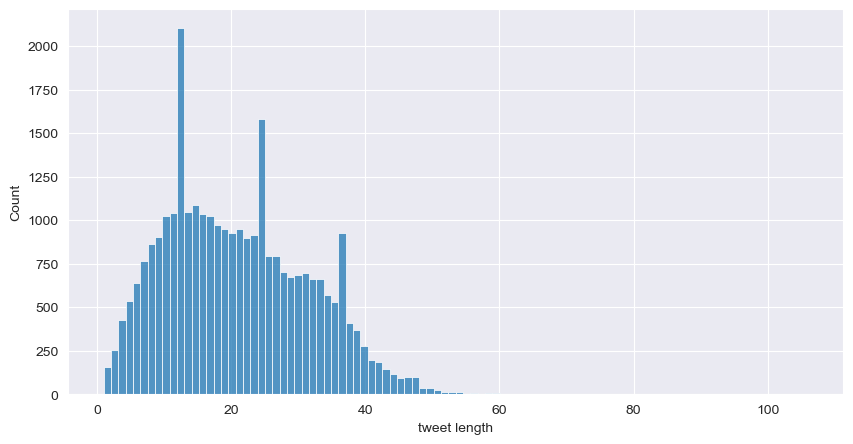

In [20]:
# Check tweet lengths distribution
token_lens = [len(tweet['input_ids']) for tweet in text_dict['tweets'].values()]

_, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.histplot(token_lens, ax=ax)
ax.set_xlabel('tweet length')
print(f'Maximal tweet length in terms of BERT tokens: {max(token_lens)}')